# **DEFECT DETECTION USING SVM**

In [2]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow

# **DATA PREPARATION**


In [4]:

def prepare_dataset(dataset_dict):

    X, y = [], []
    for label, files in dataset_dict.items():
        for f in files:
            feat, _, _ = extract_features_and_contours(f)
            if feat is not None:
                X.append(feat)
                y.append(label)
    return np.array(X), np.array(y)


# **FEATURE** **EXTRACTION**

In [3]:

def extract_features_and_contours(image_path):

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        25, 7
    )

    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    main_contour = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:
            continue
        main_contour = cnt

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        perimeter = cv2.arcLength(cnt, True)

        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0

        extent = float(area) / (w * h)

        hu = cv2.HuMoments(cv2.moments(cnt)).flatten()

        feat = [area, perimeter, aspect_ratio, solidity, extent] + list(hu)
        features.append(feat)

    if len(features) == 0:
        return None, img, None

    return np.mean(features, axis=0), img, main_contour


# **MODEL TRAINING**

In [5]:
def train_svm(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = SVC(kernel="rbf", C=10, gamma=0.001)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model


# **MODEL INFERENCE**

In [6]:

def predict_and_visualize(image_path, model):

    feat, img, contour = extract_features_and_contours(image_path)
    if feat is None:
        print("No object detected.")
        return None

    # Prediction
    pred = model.predict([feat])[0]

    # Draw contour and bounding box
    if contour is not None:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Put prediction label
    cv2.putText(
        img, f"Prediction: {pred}", (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return pred

# **RESULT VISUALIZATION**


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Classification Report:
               precision    recall  f1-score   support

         Cut       0.00      0.00      0.00       0.0
        Good       0.00      0.00      0.00       2.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0


--- Predictions on all images ---


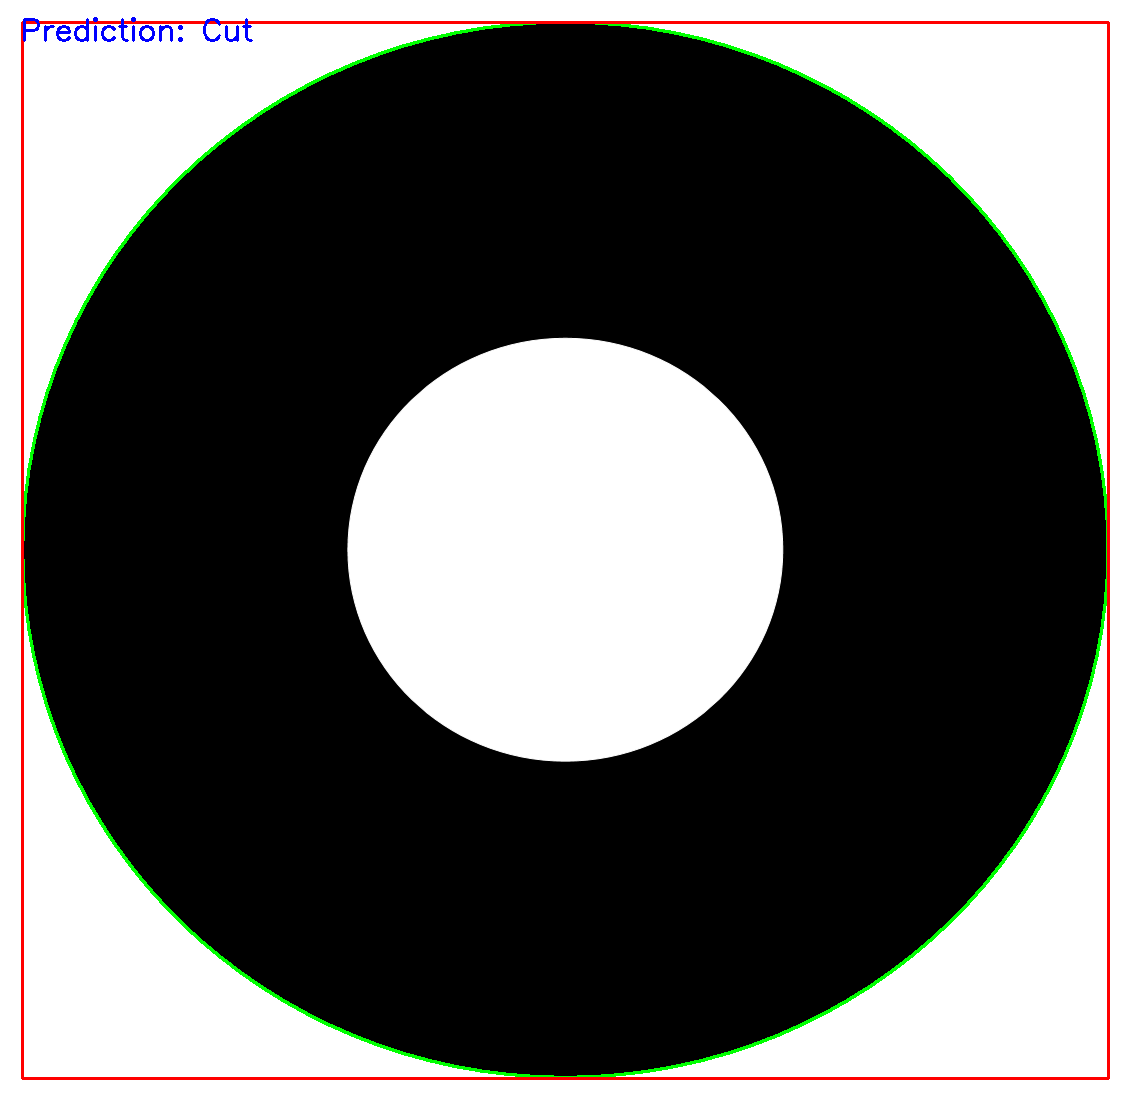

Image: image_path/good.png | Actual: Good | Predicted: Cut


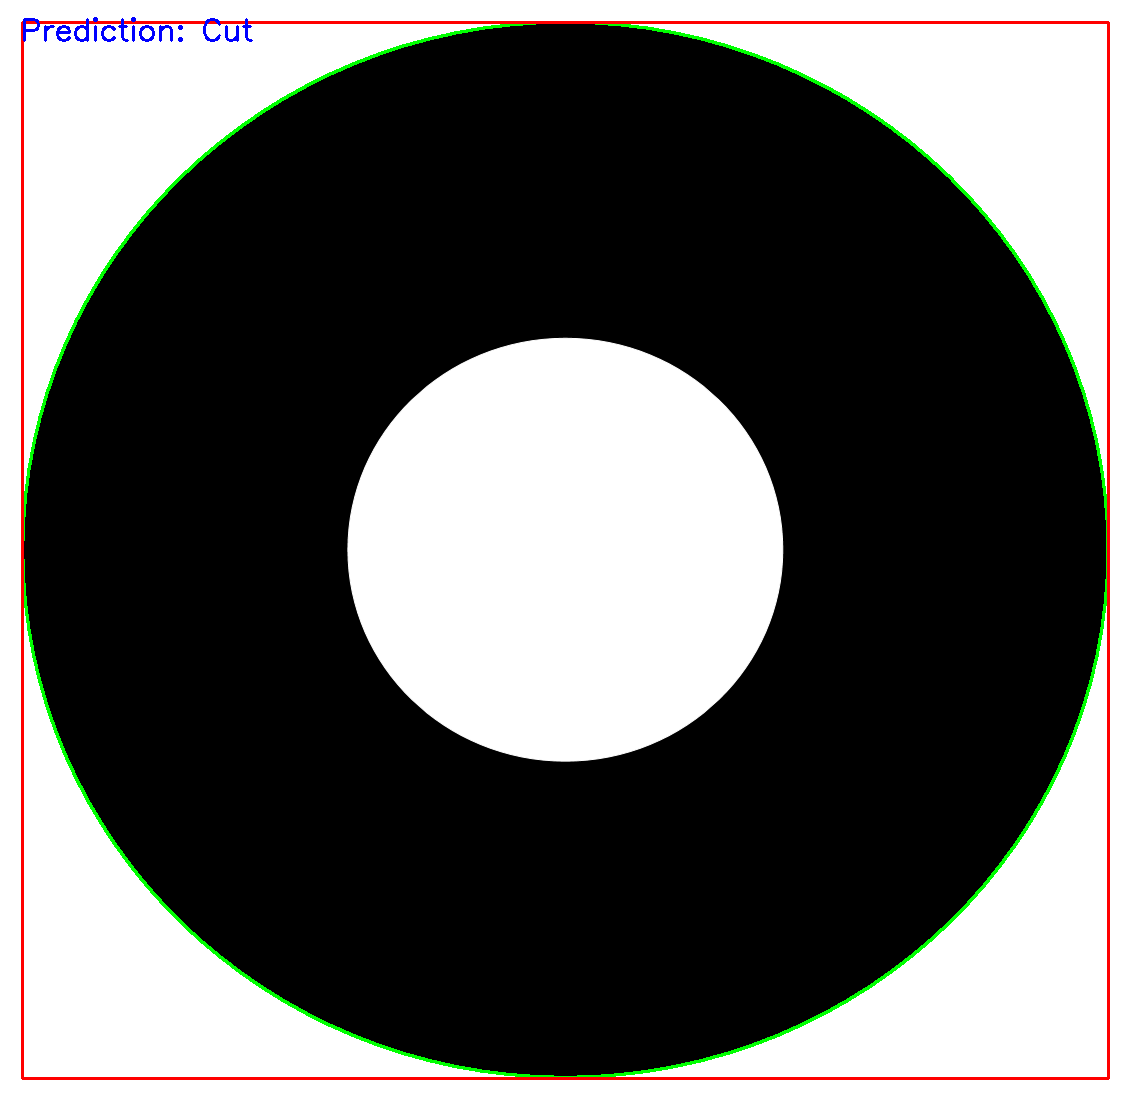

Image: image_path/good.png | Actual: Good | Predicted: Cut


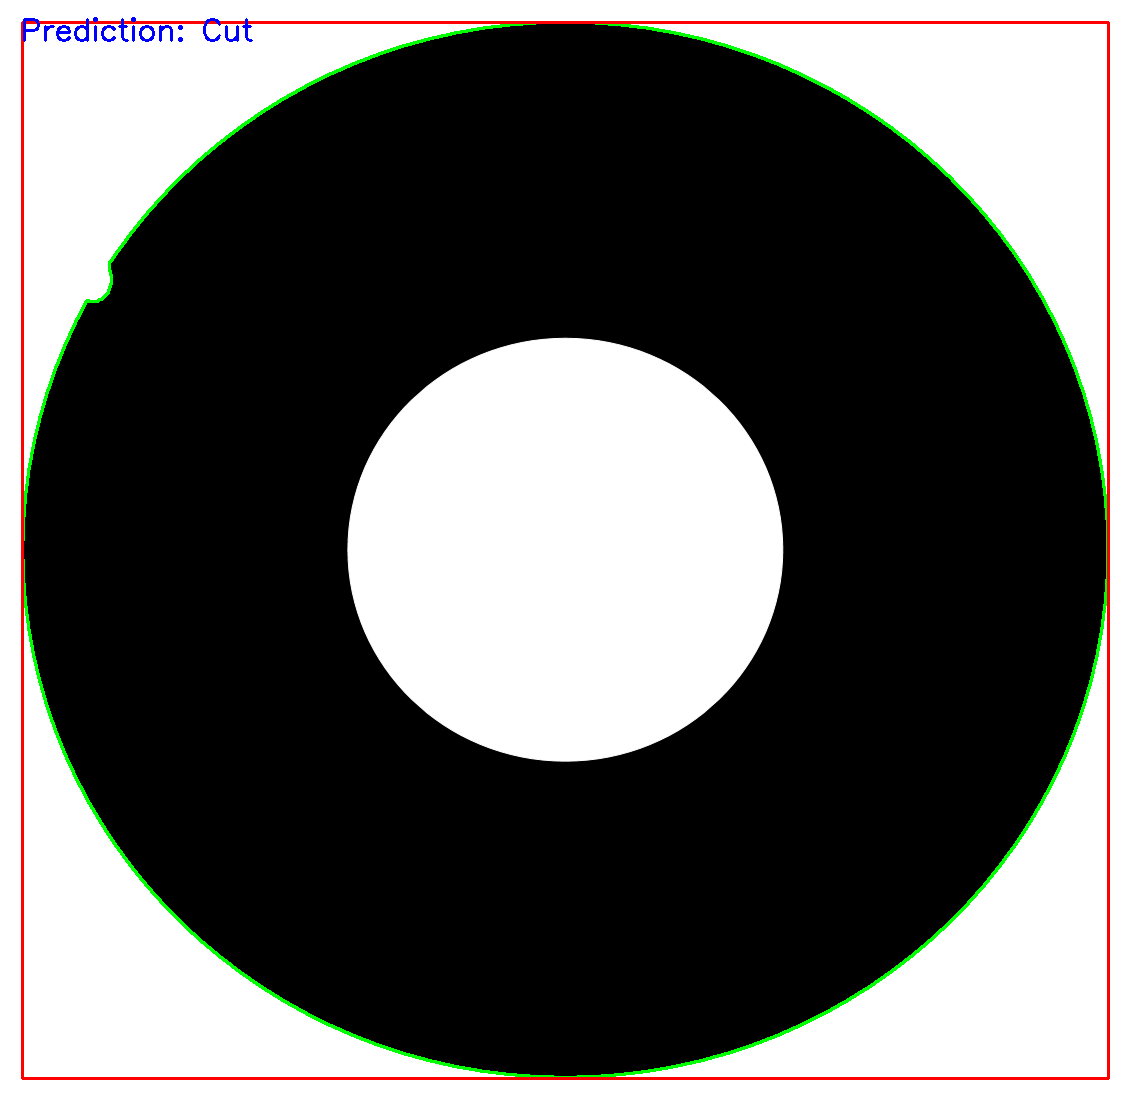

Image: image_path/defect2.png | Actual: Cut | Predicted: Cut


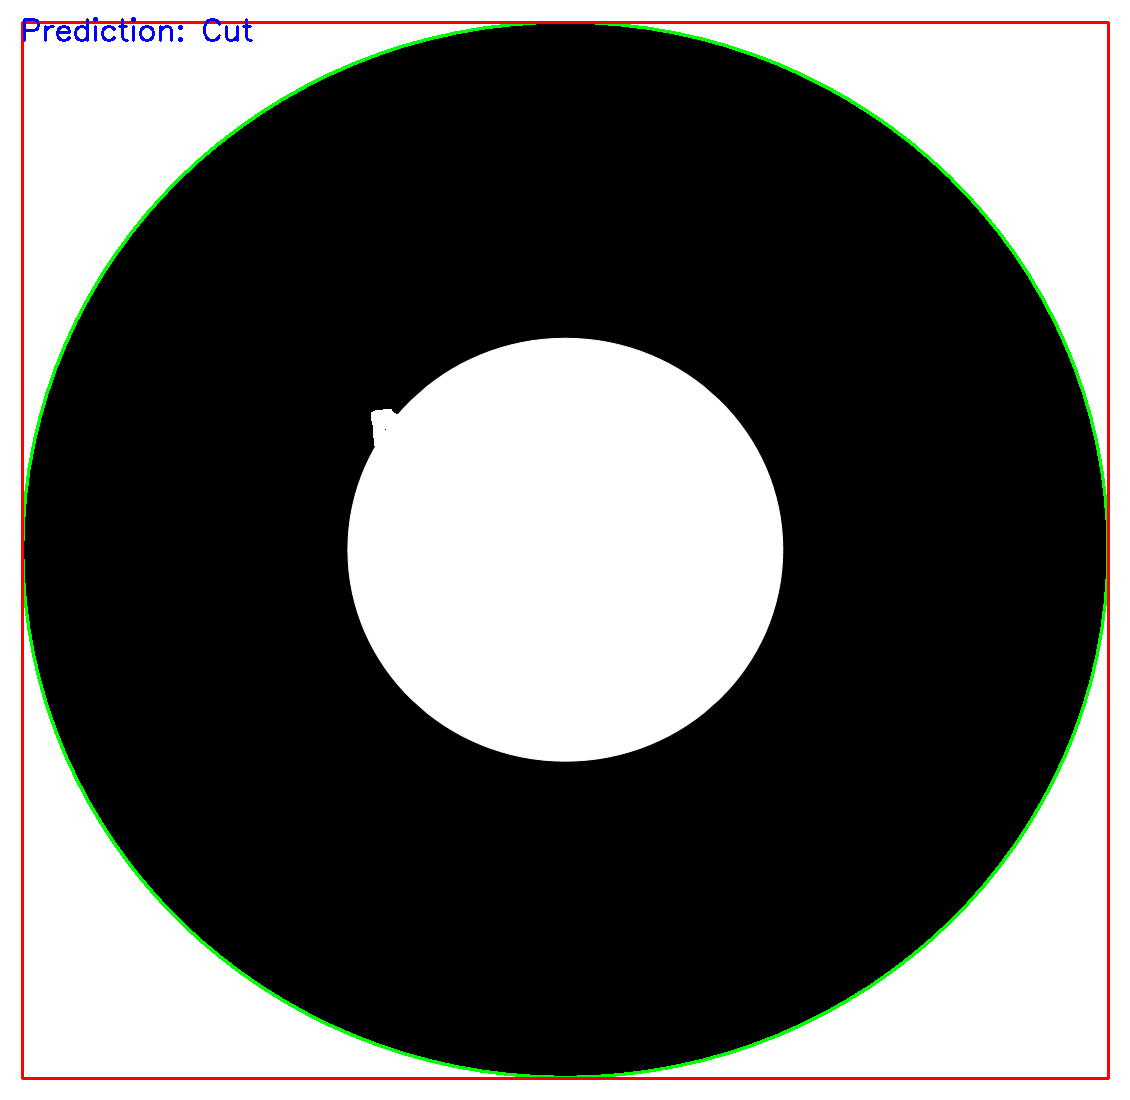

Image: image_path/defect3.png | Actual: Cut | Predicted: Cut


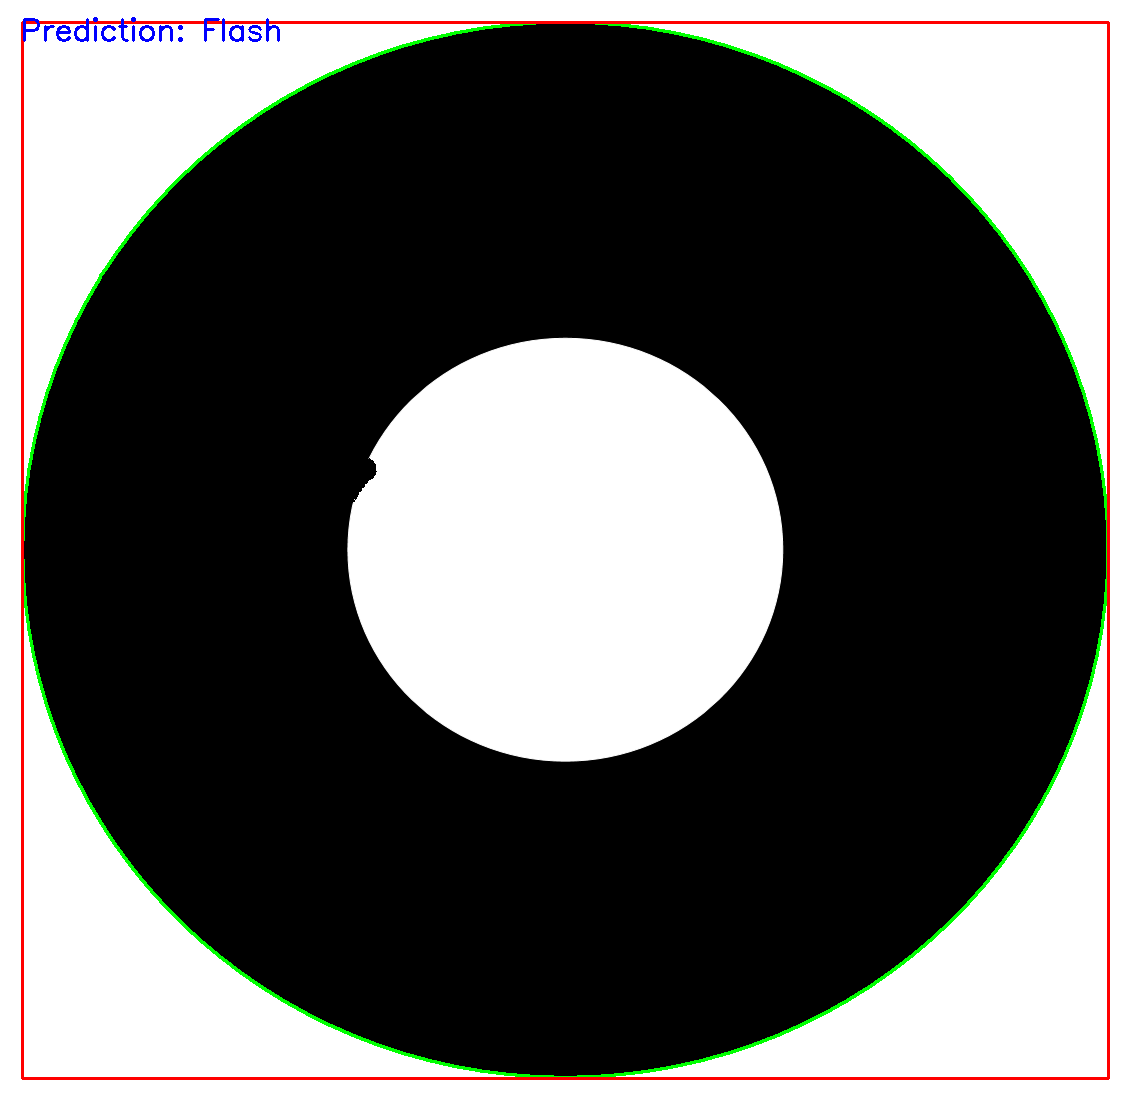

Image: image_path/defect1.png | Actual: Flash | Predicted: Flash


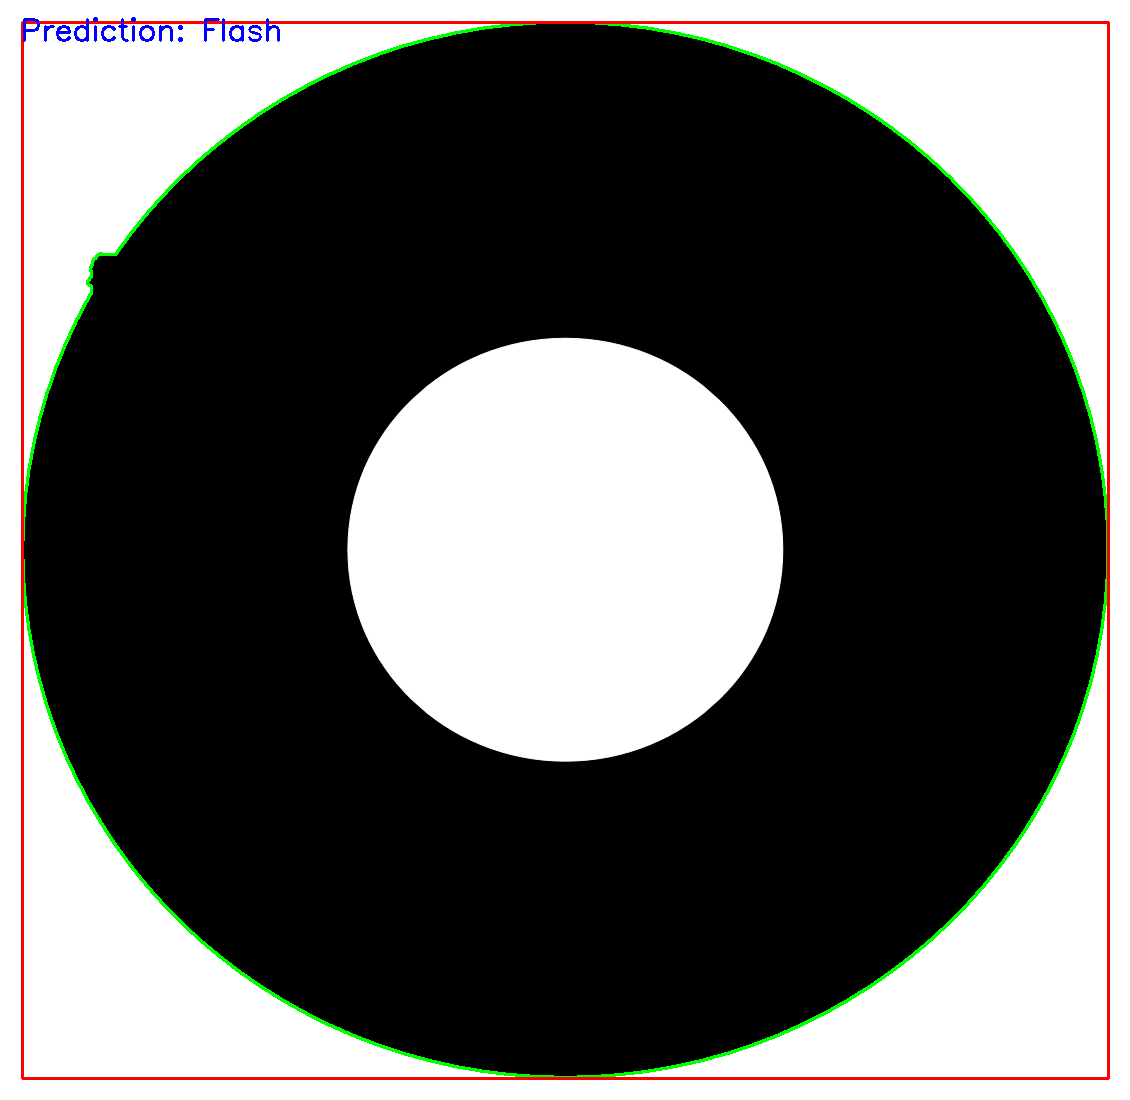

Image: image_path/defect4.png | Actual: Flash | Predicted: Flash


In [11]:

if __name__ == "__main__":

    dataset = {
        "Good": ["image_path/good.png", "image_path/good.png"],
        "Cut": ["image_path/defect2.png", "image_path/defect3.png"],
        "Flash": ["image_path/defect1.png", "image_path/defect4.png"]
    }


    X, y = prepare_dataset(dataset)

    svm_model = train_svm(X, y)

    print("\n--- Predictions on all images ---")
    for label, img_paths in dataset.items():
        for img_path in img_paths:
            result = predict_and_visualize(img_path, svm_model)
            print(f"Image: {img_path} | Actual: {label} | Predicted: {result}")
